# Change in exposure to heatwaves

## Original method

Heat waves are defined here using the index proposed in Jacob et al. [2013] modified to use daily minimum temperature data instead of maximum. Any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005) is considered to be a heat wave. The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).

## Proposed new method

Heat waves are defined as any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all seasons for the recent past (1986-2005) is considered to be a heat wave. The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).

## Trends and exposure risk

To calculate the exposure of people to heatwave, we consider only the population over 65. This older population is more vulnerable to health impacts from heatwaves.

General trends are calculated by comparing the global trend in number of heatwave days (mean days per year in heatwave conditions) and the population-weighted trend in heatwave days.

 
The heatwave risk H is measured as the change in heatwave frequency ∆H multiplied by the population:

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.

This produces a 'heatwave exposure' indicator measured in heatwave-persons.


In [2]:
%matplotlib inline

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [67]:
MAX_YEAR = 2019
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2020'

POPULATION_FILE = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'

DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographics_fraction_1950_2050.nc'


In [5]:
MAP_PROJECTION = ccrs.EckertIII()

## Load country data

In [6]:
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

In [7]:
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

In [8]:
land_mask  = (COUNTRIES_RASTER.country_codes < 1000)

### Load temperature thresholds

In [9]:
t_min_threshold = (xr.open_dataset(WEATHER_SRC / 'era5' / 'daily_tas_quantiles_1986-2005.nc')
                   .t_min
                   .sel(quantile=0.99, drop=True)
                   .load())

In [10]:
t_min_summer_threshold = (xr.open_dataset(WEATHER_SRC / 'era5' / 'daily_summer_tas_quantiles_1986-2005.nc')
                          .t_min
                          .sel(quantile=0.99, drop=True)
                          .load())

### Load population and demographic data

In [11]:
demographics = xr.open_dataarray(DEMOGRAPHICS_FILE)
fraction_over_65 = demographics.sel(age_band_lower_bound=65, drop=True).load()
population = xr.open_dataarray(POPULATION_FILE)

In [12]:
population_over_65 = population * fraction_over_65

### Load heatwave data for new method


In [13]:
heatwaves_counts = xr.open_dataarray(DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2020' / 'heatwaves_counts_1980-2019.nc')
heatwaves_days = xr.open_dataarray(DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2020' / 'heatwaves_days_1980-2019.nc')

### Load heatwave data for the old method using summer only

In [14]:
summer_heatwaves_days = xr.open_dataarray('/home/jonathanchambers/Data/lancet/heatwaves/results_2020/summer_heatwaves_days_1980-2019.nc')

In [52]:
# summer_heatwaves_counts = xr.open_dataarray(DATA_SRC / 'lancet'/ 'heatwaves'/ 'heatwave_paper_2019' / 'summer_heatwaves_counts.nc')
eraI_summer_heatwaves_days = xr.open_dataarray(DATA_SRC / 'lancet'/ 'heatwaves'/ 'heatwave_paper_2019' / 'summer_heatwaves_lengths.nc')

### Deltas ERA I Original (summer) version

In [53]:
eraI_summer_heatwaves_days_reference = eraI_summer_heatwaves_days.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
eraI_summer_heatwaves_days_delta = eraI_summer_heatwaves_days - eraI_summer_heatwaves_days_reference

### Deltas Original (summer) version

In [16]:
# summer_heatwaves_counts_reference = summer_heatwaves_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
# summer_heatwaves_counts_delta = summer_heatwaves_counts - summer_heatwaves_counts_reference

In [17]:
summer_heatwaves_days_reference = summer_heatwaves_days.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
summer_heatwaves_days_delta = summer_heatwaves_days - summer_heatwaves_days_reference

### Delta New (whole year) version

In [18]:
# heatwaves_counts_reference = heatwaves_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
# heatwaves_counts_delta = heatwaves_counts - heatwaves_counts_reference

In [19]:
heatwaves_days_reference = heatwaves_days.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwaves_days_delta = heatwaves_days - heatwaves_days_reference

# Compare the threshold values when we take whole year vs summer only

In [20]:
threshold_delta = t_min_threshold - t_min_summer_threshold

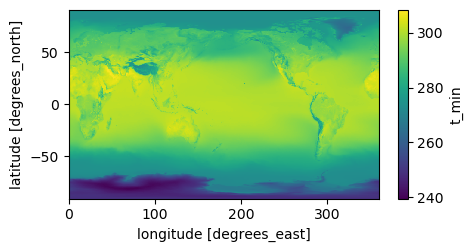

In [21]:
t_min_threshold.plot()

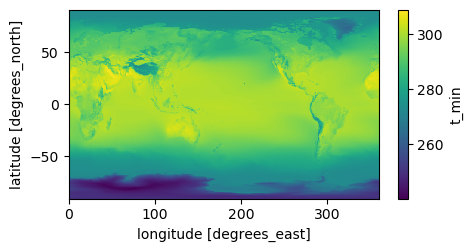

In [22]:
t_min_summer_threshold.plot()

### Plot of diffreences between old and new thresholds

#### Observations

- The deltas are mainly within ±2˚
- There is a clear latitude dependence of the difference in thresholds
- In colder places, the threshold is 'pulled down' by the inclusion of colder seasons in the distribution from which we calculate the 99th percentile
- Conversely, in many places we see a clear increase in the temperature which proves that the hottest periods of the year were *not* being captured by the previous indicator!
- If you squint a bit you can see a splash on india showing a higher threshold there indicating we weren't really getting the hottest season
- It's a bit tricky to estimate the impact on the actual heatwave occurrances though - while a higher threshold would mean less days counted as heatwaves using the old data, in fact we add the whole year data for **both** the threshold and the heatwave calculation. 
    - Therefore could expect the changes to cancel out to some extent for the hot times
    - For the decreased thresholds I'm a bit less sure - we add more data into consideration but it's all 'cold' data, since for the event calculation we care about the absolute threshold not the relative distribtuion of temperatures for that year we would I think just capture more heatwave days than before.

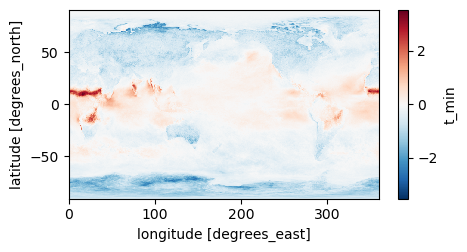

In [23]:
threshold_delta.plot()

In [24]:
threshold_delta.mean(dim='longitude').plot()

# Compare the baseline (reference) heatwave event data between the whole year and just the summer

### Observations

- New method almost always has same or higher value that old method
- Max is 3.25
- Percentage changes ?? High but just cus you change from 0 to 1 or something... Not really a good way to see the change
- 

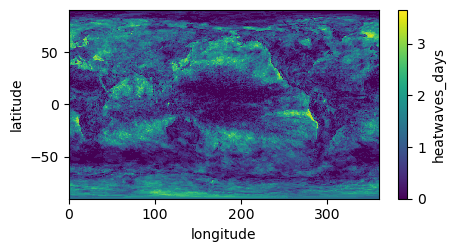

In [25]:
heatwaves_days_reference.plot()

In [26]:
reference_days_delta = heatwaves_days_reference - summer_heatwaves_days_reference

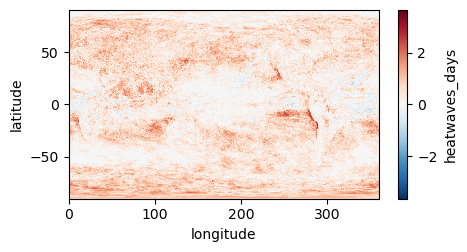

In [27]:
reference_days_delta.plot()

In [29]:
# (100 * reference_days_delta / heatwaves_days_reference).plot()

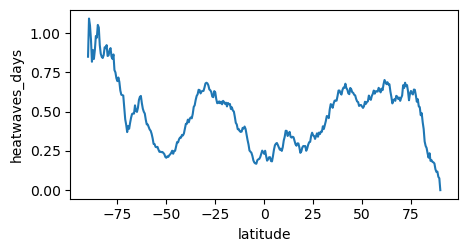

In [30]:
reference_days_delta.mean(dim='longitude').plot()

# Number of heatwaves days global mean compared to vulnerable population weighted mean


> NOTE : do you really need to compare against the reference period for this one?

In [31]:
# Get the grid weighting factor from the latitude
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwaves_days.latitude))

# Total population to normalise
total_pop_over_65 = population_over_65.sum(dim=['latitude', 'longitude'], skipna=True)

In [56]:
eraI_summer_global_mean_heatwave_days = (eraI_summer_heatwaves_days_delta * cos_lat).mean(dim=['latitude', 'longitude'])
eraI_summer_weighted_mean_heatwave_days = (eraI_summer_heatwaves_days_delta * population_over_65 / total_pop_over_65).sum(dim=['latitude', 'longitude'], skipna=True)

In [57]:
summer_global_mean_heatwave_days = (summer_heatwaves_days_delta * cos_lat).mean(dim=['latitude', 'longitude'])
summer_weighted_mean_heatwave_days = (summer_heatwaves_days_delta * population_over_65 / total_pop_over_65).sum(dim=['latitude', 'longitude'], skipna=True)

In [33]:
global_mean_heatwave_days = (heatwaves_days_delta * cos_lat).mean(dim=['latitude', 'longitude'])
weighted_mean_heatwave_days = (heatwaves_days_delta * population_over_65 / total_pop_over_65).sum(dim=['latitude', 'longitude'], skipna=True)

In [55]:
# previous_mean_heatwave_days = pd.read_excel(Path('../2019 notebooks/results/1.2 heatwaves')/ 'heatwave_exposure.xlsx', sheet_name='heatwaves_lengths').set_index('year')
# previous_mean_heatwave_days.head()

In [37]:
# f, axs = plt.subplots(1,2, sharex=True, sharey=True)
# ax=axs[0]

# delta = summer_global_mean_heatwave_days['Area weighted change (days)'] - previous_mean_heatwave_days['Area weighted change (days)']
# print(f'Difference between ERA5 and ERAI global mean: {delta.loc[2000:].mean():.2f} ± {2*delta.loc[2000:].std():.2f}',)

# sns.distplot(delta.loc[2000:],ax=ax, kde=False)
# ax.set(
#     title='Global mean',
#     xlabel='Yearly difference [Days]',
#     ylabel='Frequency density',
# #     xlim=(2000, 2018)
# )

# # ax.legend(bbox_to_anchor=(1.2, -0.2), fancybox=False, ncol=2)

# ax=axs[1]
# delta = summer_weighted_mean_heatwave_days['Exposure weighted change (days)'] - previous_mean_heatwave_days['Exposure weighted change (days)']
# print(f'Difference between ERA5 and ERAI global mean: {delta.loc[2000:].mean():.2f} ± {2*delta.loc[2000:].std():.2f}',)

# # delta.loc[2000:].plot.hist(ax=ax)
# sns.distplot(delta.loc[2000:],ax=ax, kde=False)

# ax.set(
#     title='Exposure weighted mean',
#     xlabel='Yearly difference [Days]',
# #     ylabel='days',
# )
# f.suptitle('Distribution of differences between ERA5 and ERA-Interim', y=1.05)

# # plt.tight_layout()
# # ax.legend(bbox_to_anchor=(1.2, -0.2), fancybox=False, ncol=2)
# f.savefig(str(RESULTS_FOLDER / f'era5_erai_delta_dist_2000-{MAX_YEAR}.png'), bbox_inches='tight')

### Compare using ERA5 data the summer-only and all year index results

In [59]:
cpal = sns.color_palette("Paired")
sns.palplot(cpal)

In [83]:
cpal = sns.color_palette("Paired")

# Plot the change in mean length of heatwaves over time, comparing the global average with the population weighted average
f, ax = plt.subplots()

eraI_summer_global_mean_heatwave_days.plot(color=cpal[1], linestyle='-',label='ERAI Global mean (summer)', ax=ax)

summer_global_mean_heatwave_days.plot(color=cpal[3], linestyle=':',label='ERA5 Global mean (summer)', ax=ax)

global_mean_heatwave_days.plot(color=cpal[5],linestyle='-.',label='ERA5 Global mean', ax=ax)


ax.set(
    title='Change in yearly mean number of heatwave days',
    xlabel='Year',
    ylabel='[∆N days]',
    xlim=(1980, MAX_YEAR)
)
ax.legend(bbox_to_anchor=(0.9, -0.2), fancybox=False, ncol=1)
f.savefig(str(RESULTS_FOLDER / f'method_comp_global_mean-{MAX_YEAR}.png'), bbox_inches='tight')

In [86]:
cpal = sns.color_palette("Paired")

# Plot the change in mean length of heatwaves over time, comparing the global average with the population weighted average
f, ax = plt.subplots()

eraI_summer_weighted_mean_heatwave_days.plot(color=cpal[1], linestyle='-',label='ERAI Exposure weighted mean (summer)', ax=ax)

summer_weighted_mean_heatwave_days.plot(color=cpal[3], linestyle=':',label='ERA5 Exposure weighted mean (summer)', ax=ax)

weighted_mean_heatwave_days.plot(color=cpal[5],linestyle='-.',label='ERA5 Exposure weighted mean', ax=ax)


ax.set(
    title='Change in yearly exposure weighted mean number \nof heatwave days',
    xlabel='Year',
    ylabel='[∆N days]',
    xlim=(1980, MAX_YEAR)
)
ax.legend(bbox_to_anchor=(0.9, -0.2), fancybox=False, ncol=1)
f.savefig(str(RESULTS_FOLDER / f'method_comp_expo_mean-{MAX_YEAR}.png'), bbox_inches='tight')

In [87]:
# cpal = sns.color_palette("Paired")

# # Plot the change in mean length of heatwaves over time, comparing the global average with the population weighted average
# f, ax = plt.subplots()
# summer_global_mean_heatwave_days.plot(color=cpal[1], linestyle=':',label='Global mean (summer)', ax=ax)
# summer_weighted_mean_heatwave_days.plot(color=cpal[0],label='Exposure weighted mean (summer)', ax=ax)

# global_mean_heatwave_days.plot(color=cpal[5],linestyle='-.',label='Global mean', ax=ax)
# weighted_mean_heatwave_days.plot(color=cpal[4],linestyle='--',label='Exposure weighted mean', ax=ax)


# ax.set(
#     title='Change in heatwave days',
#     xlabel='Year',
#     ylabel='Change in yearly number\n of heatwave days',
#     xlim=(1980, MAX_YEAR)
# )
# ax.legend(bbox_to_anchor=(1.2, -0.2), fancybox=False, ncol=2)
# f.savefig(str(RESULTS_FOLDER / f'heatwaves_all_vs_summer_2000-{MAX_YEAR}.png'), bbox_inches='tight')

## Compare absolute person-days exposure changes

In [91]:
eraI_summer_expo_heatwave_days = (eraI_summer_heatwaves_days_delta * population_over_65).sum(dim=['latitude', 'longitude'], skipna=True)

In [88]:
summer_expo_heatwave_days = (summer_heatwaves_days_delta * population_over_65).sum(dim=['latitude', 'longitude'], skipna=True)
expo_heatwave_days = (heatwaves_days_delta * population_over_65).sum(dim=['latitude', 'longitude'], skipna=True)

In [92]:
exposures = pd.concat([
    summer_expo_heatwave_days.to_dataframe('Exposure (summer)'),
    expo_heatwave_days.to_dataframe('Exposure'),
    eraI_summer_expo_heatwave_days.to_dataframe('ERAI Exposure (summer)'),
                      ] , axis=1)

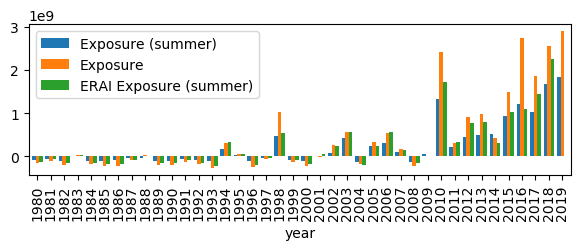

In [93]:
exposures.plot.bar(width=0.8, figsize=(7,2))

## Focus on 2015 vs 2016, this is the only year where we see a difference in the trends

- The difference is already present in the global mean values, i.e. its not an artefact of population weighting etc

> OK so it seems to be driven by the India 2016 heatwave https://en.wikipedia.org/wiki/2016_Indian_heat_wave "The 2016 Indian heat wave was a major heat wave in April and May of that year"

>In India, the month of May is typically one of the hottest and driest.[1] In 2016, the heat came early, with 111 heat-related casualties reported by 8 April.[6] Most of the heat waves in India since 1998 are associated with droughts;[7] a major drought and worsening water shortages had affected around 330 million people by 23 May.[8] The high temperatures, combined with other atmospheric disturbances, led to thunderstorms and lightning strikes in some states, leading to deaths, the destruction of houses and uprooted trees, as well as affecting crops and farm animals.[9][10] The monsoon rains that would provide some relief were nearly one week behind the scheduled date, and would not reach the north until several weeks later.[1]

---
> ALSO now i look seems to be a lot going on in western and sub-saharan africa! Like a really large area! 



In [45]:
f, axs = plt.subplots(1, 2, figsize=(6,3.5), subplot_kw=dict(projection=MAP_PROJECTION))

f_opts = dict(
    vmin=-30, vmax=30,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    cbar_kwargs={'orientation':'horizontal','label':'',},
             )

ax = axs[0]

data = heatwaves_days_delta.sel(year=2016)

p = data.plot.pcolormesh(ax=ax,**f_opts)

ax.coastlines(linewidth=0.5)

ax = axs[1]
data = summer_heatwaves_days_delta.sel(year=2016)
p = data.plot.pcolormesh(ax=ax,**f_opts)

ax.coastlines(linewidth=0.5)

f.colorbar(p, ax=axs, orientation='horizontal', shrink=0.6)

f.show()

Difference in N heatwave days for 2015

In [46]:
method_days_difference = (heatwaves_days_delta - summer_heatwaves_days_delta).compute()

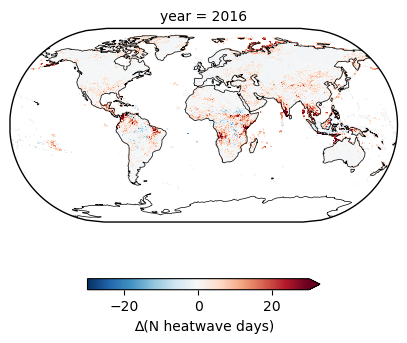

In [97]:
f, ax = plt.subplots(1, 1, figsize=(5,5), subplot_kw=dict(projection=MAP_PROJECTION))

f_opts = dict(
    vmin=-30, vmax=30,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    add_colorbar=False
             )


data = method_days_difference.sel(year=2016).where(land_mask)

p = data.plot.pcolormesh(ax=ax,**f_opts)
ax.coastlines(linewidth=0.5)

f.colorbar(p, ax=ax, orientation='horizontal', shrink=0.6, label='∆(N heatwave days)', extend='max',)


f.savefig(RESULTS_FOLDER / 'comp_hw_method_2016.png')
f.show()


In [98]:
f, axs = plt.subplots(2, 1, figsize=(5,5), subplot_kw=dict(projection=MAP_PROJECTION))

f_opts = dict(
    vmin=-30, vmax=30,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    add_colorbar=False
             )

ax = axs[0]

data = method_days_difference.sel(year=2015).where(land_mask)

p = data.plot.pcolormesh(ax=ax, **f_opts)
ax.coastlines(linewidth=0.5)


ax = axs[1]

data = method_days_difference.sel(year=2016).where(land_mask)

p = data.plot.pcolormesh(ax=ax,**f_opts)
ax.coastlines(linewidth=0.5)

f.colorbar(p, ax=axs, orientation='vertical', shrink=0.6, label='∆(N heatwave days)', extend='max',)


f.savefig(RESULTS_FOLDER / 'comp_hw_method.png', bbox_inches='tight')
f.show()


## Focus on some of the regions with more changes

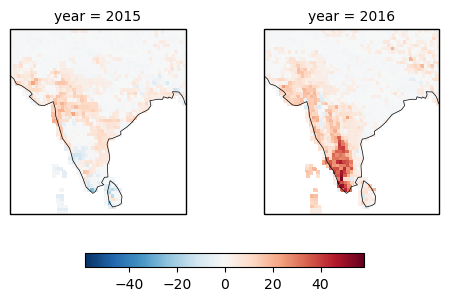

In [50]:

f, axs = plt.subplots(1, 2, figsize=(6,3.5), subplot_kw=dict(projection=MAP_PROJECTION))

f_opts = dict(add_colorbar=False,
    transform=ccrs.PlateCarree(),)


ax = axs[0]
data = method_days_difference.sel(year=2015).where(land_mask)

ax.set_extent([67.5,91,5.0,32], crs=ccrs.PlateCarree())
p = data.plot.pcolormesh(ax=ax, **f_opts)
ax.coastlines(linewidth=0.5)


ax = axs[1]

data = method_days_difference.sel(year=2016).where(land_mask)

ax.set_extent([67.5,91,5.0,32], crs=ccrs.PlateCarree())
p = data.plot.pcolormesh(ax=ax, **f_opts)
ax.coastlines(linewidth=0.5)

f.colorbar(p, ax=axs, orientation='horizontal', shrink=0.6)

# f.savefig(RESULTS_FOLDER / 'comp_hw_method.png', bbox_inches='tight')

f.show()


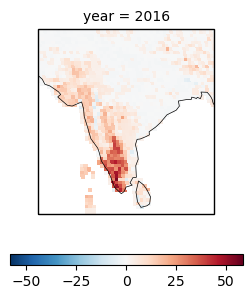

In [100]:

f, axs = plt.subplots(1, 1, figsize=(6,3.5), subplot_kw=dict(projection=MAP_PROJECTION))

f_opts = dict(add_colorbar=False,
    transform=ccrs.PlateCarree(),)


ax = axs

data = method_days_difference.sel(year=2016).where(land_mask)

ax.set_extent([67.5,91,5.0,32], crs=ccrs.PlateCarree())
p = data.plot.pcolormesh(ax=ax, **f_opts)
ax.coastlines(linewidth=0.5)

f.colorbar(p, ax=axs, orientation='horizontal', shrink=0.5)

f.savefig(RESULTS_FOLDER / 'comp_hw_method_india_2016.png', bbox_inches='tight')

f.show()


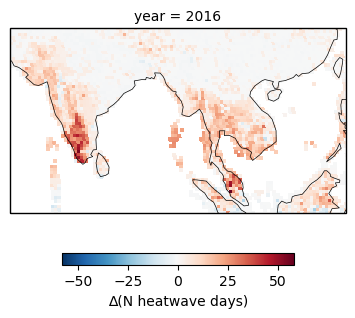

In [108]:

f, axs = plt.subplots(1, 1, figsize=(6,3.5), subplot_kw=dict(projection=MAP_PROJECTION))

f_opts = dict(add_colorbar=False,
    transform=ccrs.PlateCarree(),)


ax = axs

data = method_days_difference.sel(year=2016).where(land_mask)

ax.set_extent([67.5,120,0.0,30], crs=ccrs.PlateCarree())
p = data.plot.pcolormesh(ax=ax, **f_opts)
ax.coastlines(linewidth=0.5)

f.colorbar(p, ax=axs, orientation='horizontal', shrink=0.5, label='∆(N heatwave days)')

f.savefig(RESULTS_FOLDER / 'comp_hw_method_seasia_2016.png', bbox_inches='tight')

f.show()
